## Training
Prepapre dataset with the prepare_dataset notebook, before running this one.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import scipy.io as sio
from time import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import calc_gso_batch
import seaborn as sns
sns.set_style("darkgrid")

device = torch.device("mps") # apple silicon
# device = torch.device("cpu") # cpu
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # nvidia
print(f'device: {device}')

def to_tensor(x, device=torch.device("cpu")): return torch.tensor(x, dtype=torch.float32, device=device)

device: mps


# Best MSE loss: 0.087

In [2]:
MODEL_SAVE_PATH = "mg_data/mg_planet.pth"
EPOCHS = 20
BATCH_SIZE = 512
LEARNING_RATE = 3e-3
GSO_LOSS_RATIO = 0.2
USE_CURRENTS = True
USE_PROFILES = False
USE_MAGNETIC = True
INPUT_SIZE = int(USE_CURRENTS)*14 + int(USE_PROFILES)*202 + int(USE_MAGNETIC)*187
TRAIN_DS_PATH = "data/train_ds.mat" # generated from prepapre_dataset
EVAL_DS_PATH = "data/eval_ds.mat"

- mean current: -10183.76, std current: 34209.11
- mean magnetic: -0.20, std magnetic: 0.58
- mean f_profile: 33.13, std f_profile: 0.28
- mean p_profile: 9654.42, std p_profile: 8788.29

In [3]:
class PlaNetDataset(Dataset):
    def __init__(self, ds_mat_path):
        ds_mat = sio.loadmat(ds_mat_path)
        # output: magnetic flux, transposed (matlab is column-major)
        self.psi = to_tensor(ds_mat["psi"]).view(-1, 1, 64, 64)
        # inputs: radial and vertical position of pixels (for plotting only rn) + currents + measurements + profiles 
        self.rr = to_tensor(ds_mat["rr"]).view(-1,1,64,64) # radial position of pixels (64, 64)
        self.zz = to_tensor(ds_mat["zz"]).view(-1,1,64,64) # vertical position of pixels (64, 64)
        self.currs = ds_mat["currs"] # input currents (n, 14)
        self.magnetic = ds_mat["magnetic"] # input magnetic measurements (n, 187)
        self.f_profile = ds_mat["f_profiles"] # input profiles (n, 101)
        self.p_profile = ds_mat["p_profiles"] # input profiles (n, 101)
        inputs = [] # add the normalized inputs to the list
        if USE_CURRENTS: inputs.append((to_tensor(self.currs)+10183)/34209) # (n, 14)
        if USE_MAGNETIC: inputs.append((to_tensor(self.magnetic)+0.2)/0.58) # (n, 187)
        if USE_PROFILES: inputs.append(torch.cat(((to_tensor(self.f_profile)-33.13)/0.28, 
                                                  (to_tensor(self.p_profile)-9654)/8788), 1)) # (n, 202)
        self.inputs = torch.cat(inputs, 1) # (n, 403)
    def __len__(self): return len(self.psi)
    def __getitem__(self, idx): return self.inputs[idx], self.psi[idx], self.rr[idx], self.zz[idx]

In [4]:
# test dataset
ds = PlaNetDataset(EVAL_DS_PATH)
print(f"Dataset length: {len(ds)}")
print(f"Input shape: {ds[0][0].shape}")
print(f"Output shape: {ds[0][1].shape}")

Dataset length: 10000
Input shape: torch.Size([201])
Output shape: torch.Size([1, 64, 64])


In [5]:
class PlaNet(nn.Module): # upsample convolutional neural network > slower > but smoother
    def __init__(self):
        super(PlaNet, self).__init__()
        self.interp = 'bilinear' # 'nearest' or 'bilinear'
        self.n = n = 16
        self.fc = nn.Sequential(
            nn.Linear(INPUT_SIZE, 8*n),
            nn.ReLU(),
            nn.Linear(8*n, 16*n),
            nn.ReLU(),
        )
        self.unconv = nn.Sequential(
            nn.Upsample(scale_factor=4, mode=self.interp),
            nn.Conv2d(16*n, 8*n, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8*n), # batch normalization
            nn.Upsample(scale_factor=2, mode=self.interp),
            nn.Conv2d(8*n, 4*n, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode=self.interp),
            nn.Conv2d(4*n, 2*n, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode=self.interp),
            nn.Conv2d(2*n, n, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode=self.interp),
            nn.Conv2d(n, 1, kernel_size=3, padding=1),
        )
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 16*self.n, 1, 1)
        x = self.unconv(x)
        # x = x.view(-1, 64, 64)
        return x

In [6]:
# class PlaNet(nn.Module): # Paper net: branch + trunk conenction and everything
#     def __init__(self):
#         super(PlaNet, self).__init__()
#         self.interp = 'bilinear' # 'nearest' or 'bilinear'
#         self.n = n = 4
#         self.fc = nn.Sequential(
#             nn.Linear(INPUT_SIZE, 8*n),
#             nn.ReLU(),
#             nn.Linear(8*n, 16*n),
#             nn.ReLU(),
#         )
#         self.unconv = nn.Sequential(
#             nn.Upsample(scale_factor=4, mode=self.interp),
#             nn.Conv2d(16*n, 8*n, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(8*n), # batch normalization
#             nn.Upsample(scale_factor=2, mode=self.interp),
#             nn.Conv2d(8*n, 4*n, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Upsample(scale_factor=2, mode=self.interp),
#             nn.Conv2d(4*n, 2*n, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Upsample(scale_factor=2, mode=self.interp),
#             nn.Conv2d(2*n, n, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Upsample(scale_factor=2, mode=self.interp),
#             nn.Conv2d(n, 1, kernel_size=3, padding=1),
#         )
#     def forward(self, x):
#         x = self.fc(x)
#         x = x.view(-1, 16*self.n, 1, 1)
#         x = self.unconv(x)
#         # x = x.view(-1, 64, 64)
#         return x

In [7]:
# test model
model = PlaNet()
x = torch.randn(1, INPUT_SIZE)
print(f"Input shape: {x.shape}")
y = model(x)
print(f"Output shape: {y.shape}")

Input shape: torch.Size([1, 201])
Output shape: torch.Size([1, 1, 64, 64])


## Training

In [ ]:
train_ds, val_ds = PlaNetDataset(TRAIN_DS_PATH), PlaNetDataset(EVAL_DS_PATH) # initialize datasets
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True) # initialize DataLoader
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)  
model = PlaNet()  # instantiate model
model.to(device) # move model to device
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss() # Mean Squared Error Loss
best_loss = float('inf') # initialize best loss
for ep in range(EPOCHS): 
    epoch_time = time()
    model.train()
    trainloss, evalloss = [], []
    for input_currs, psi, rr, zz in train_dl:
        input_currs, psi, rr, zz = input_currs.to(device), psi.to(device), rr.to(device), zz.to(device) # move to device
        optimizer.zero_grad()
        psi_pred = model(input_currs)
        # print(f"psi shape: {psi.shape}, psi_pred shape: {psi_pred.shape}, rr shape: {rr.shape}, zz shape: {zz.shape}")
        gso, gso_pred = calc_gso_batch(psi, rr, zz, dev=device), calc_gso_batch(psi_pred, rr, zz, dev=device)
        mse_loss = loss_fn(psi_pred, psi) # mean squared error loss on psi
        gso_loss = loss_fn(gso_pred, gso) # PINN loss on grad shafranov
        loss = (1-GSO_LOSS_RATIO)*mse_loss + GSO_LOSS_RATIO*gso_loss # total loss
        loss.backward()
        optimizer.step()
        trainloss.append((loss.item(), mse_loss.item(), gso_loss.item()))
    model.eval()
    with torch.no_grad():
        for input_currs, psi, rr, zz in val_dl:
            input_currs, psi, rr, zz = input_currs.to(device), psi.to(device), rr.to(device), zz.to(device)
            psi_pred = model(input_currs)
            gso, gso_pred = calc_gso_batch(psi, rr, zz, dev=device), calc_gso_batch(psi_pred, rr, zz, dev=device)
            mse_loss = loss_fn(psi_pred, psi)
            gso_loss = loss_fn(gso_pred, gso)
            loss = (1-GSO_LOSS_RATIO)*mse_loss + GSO_LOSS_RATIO*gso_loss # total loss
            evalloss.append((loss.item(), mse_loss.item(), gso_loss.item()))
    ttot_loss, tmse_loss, tgso_loss = map(lambda x: sum(x)/len(x), zip(*trainloss))
    etot_loss, emse_loss, egso_loss = map(lambda x: sum(x)/len(x), zip(*evalloss))
    print(f"Ep {ep+1}/{EPOCHS}: Train Loss: {ttot_loss:.4f}, mse {tmse_loss:.4f}, gso {tgso_loss:.4f}  |  " +
          f"Eval Loss: {etot_loss:.4f}, mse {emse_loss:.4f}, gso {egso_loss:.4f}  |  t:{time()-epoch_time:.2f}s,", end=" ")
    if etot_loss < best_loss:
        best_loss = etot_loss
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print("new best")
    else: print()

Ep 1/20: Train Loss: 10.2388, mse 9.3513, gso 13.7890  |  Eval Loss: 3.4311, mse 2.5629, gso 6.9043  |  t:11.91s, new best
Ep 2/20: Train Loss: 2.1631, mse 1.2997, gso 5.6164  |  Eval Loss: 1.6707, mse 1.1446, gso 3.7750  |  t:9.06s, new best
Ep 3/20: Train Loss: 1.0809, mse 0.5927, gso 3.0341  |  Eval Loss: 2.5445, mse 2.2915, gso 3.5565  |  t:8.96s, 
Ep 4/20: Train Loss: 0.9293, mse 0.5264, gso 2.5410  |  Eval Loss: 3.9038, mse 3.9198, gso 3.8395  |  t:8.53s, 
Ep 5/20: Train Loss: 0.8544, mse 0.5106, gso 2.2296  |  Eval Loss: 1.1512, mse 0.9373, gso 2.0068  |  t:8.64s, new best
Ep 6/20: Train Loss: 0.6587, mse 0.3301, gso 1.9731  |  Eval Loss: 1.4883, mse 1.0187, gso 3.3668  |  t:8.48s, 
Ep 7/20: Train Loss: 0.6273, mse 0.3587, gso 1.7017  |  Eval Loss: 0.4505, mse 0.2513, gso 1.2475  |  t:9.19s, new best
Ep 8/20: Train Loss: 0.6449, mse 0.3316, gso 1.8984  |  Eval Loss: 1.1360, mse 1.1099, gso 1.2407  |  t:8.58s, 
Ep 9/20: Train Loss: 0.5032, mse 0.3020, gso 1.3077  |  Eval Loss: 1.

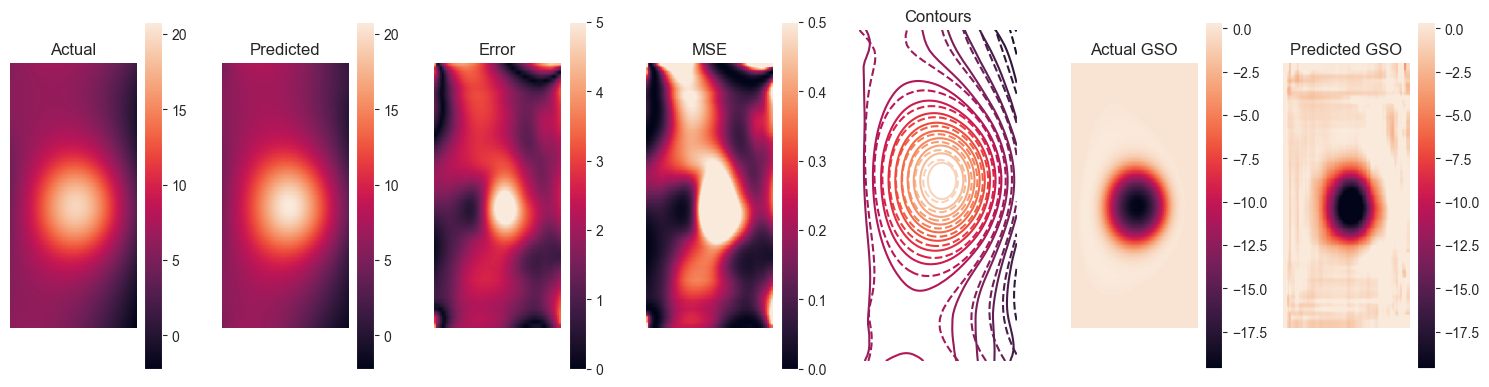

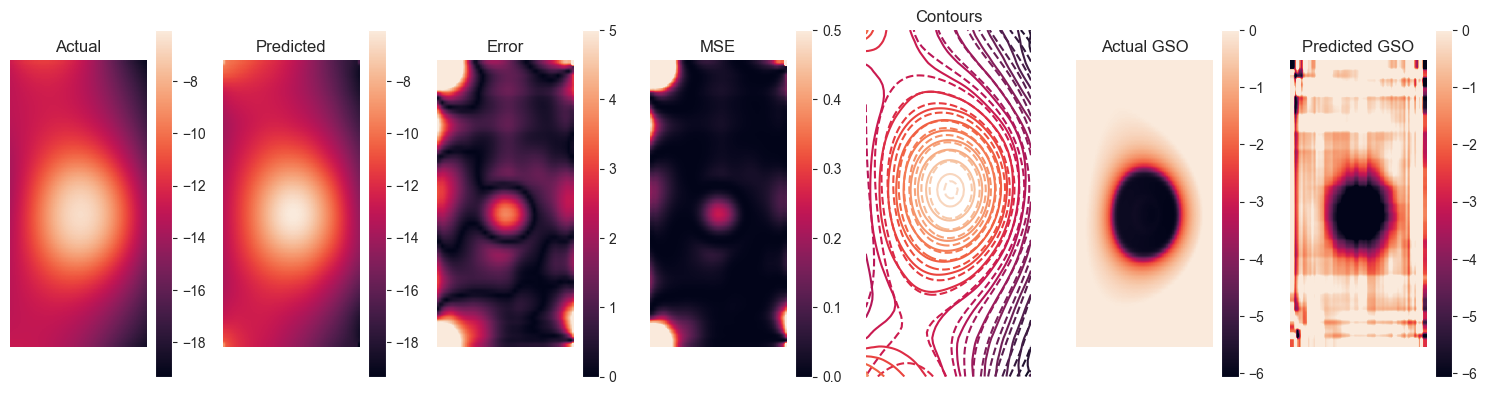

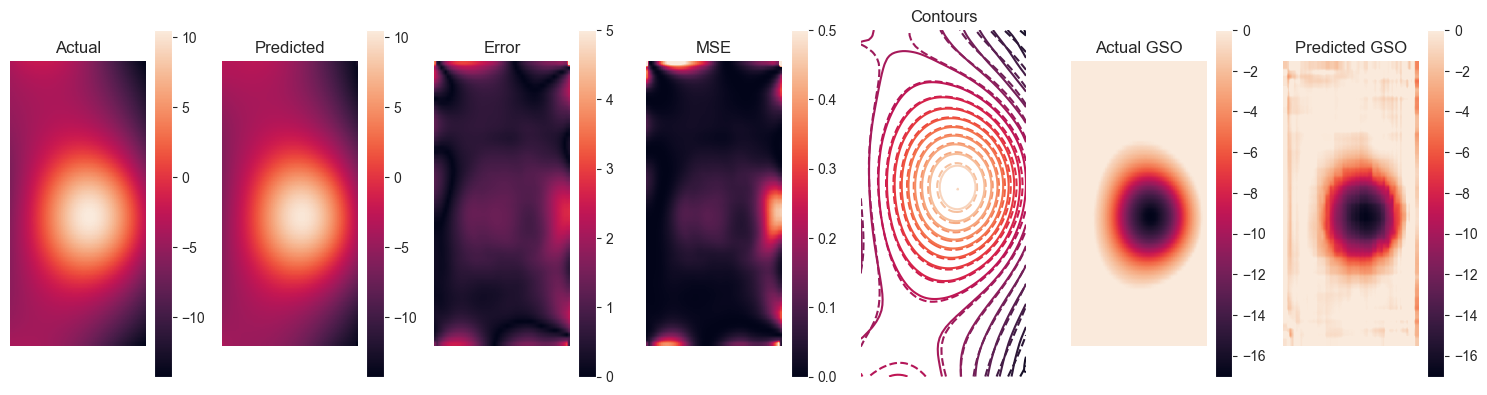

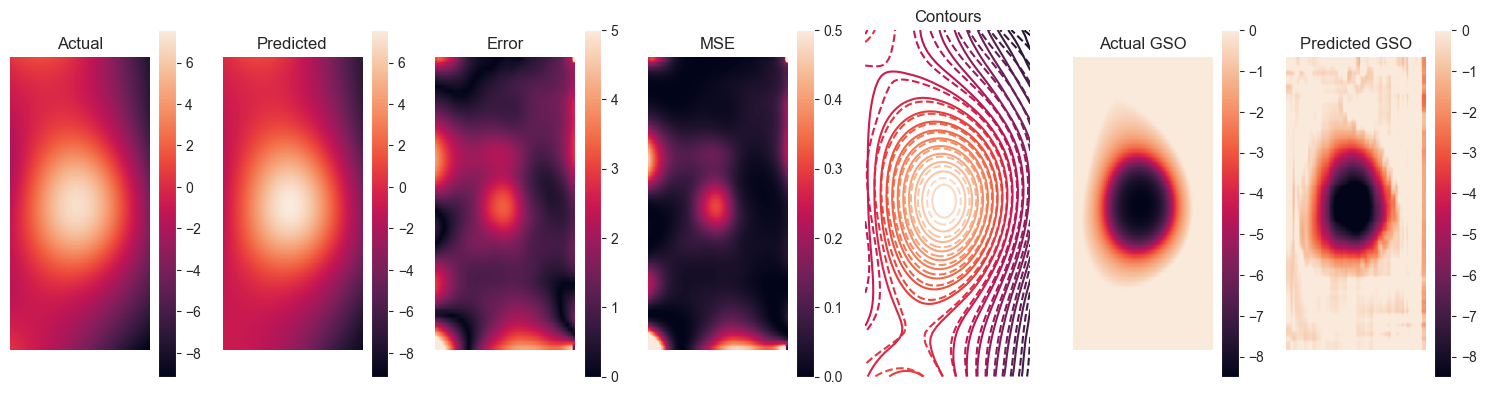

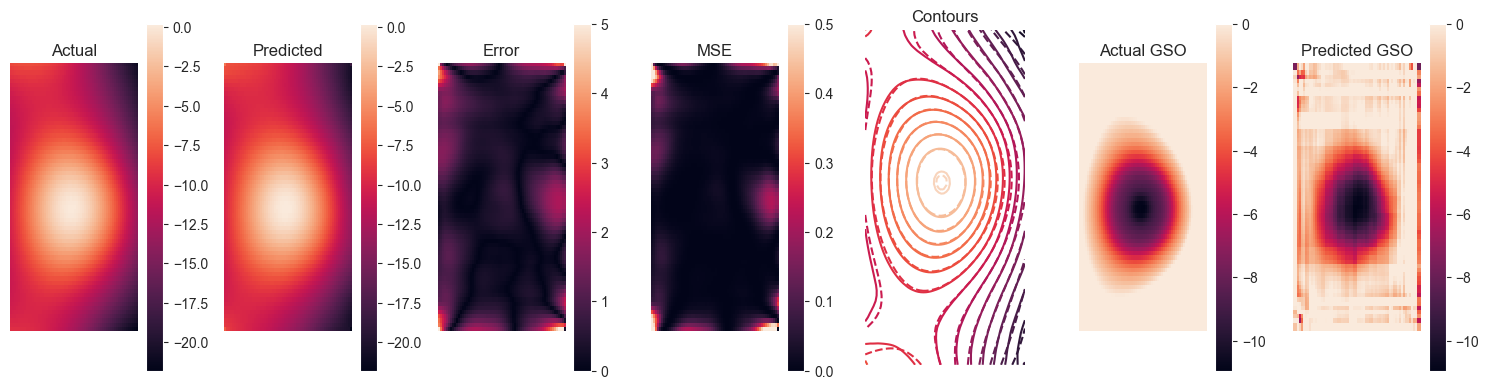

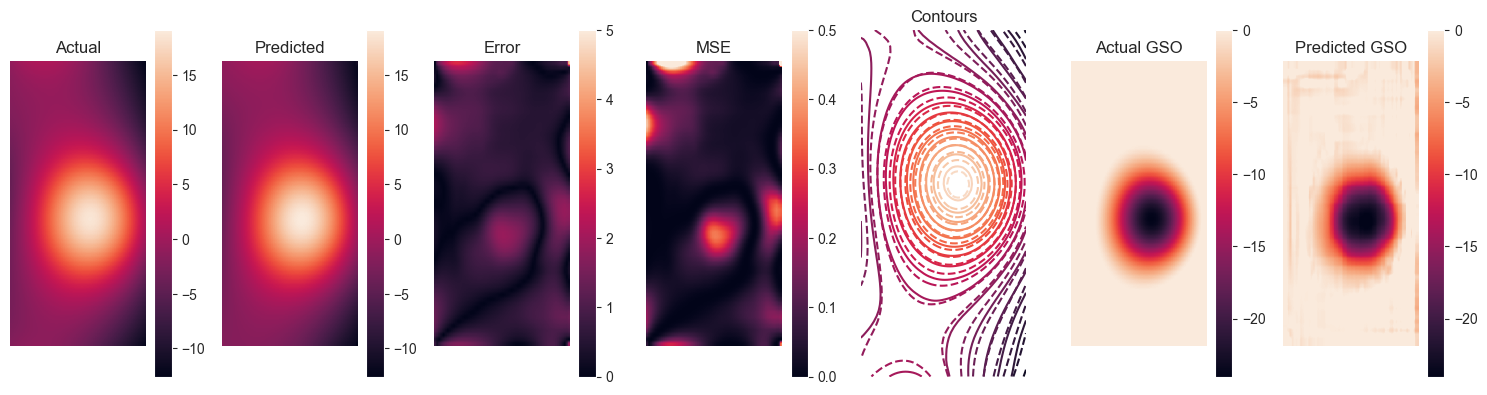

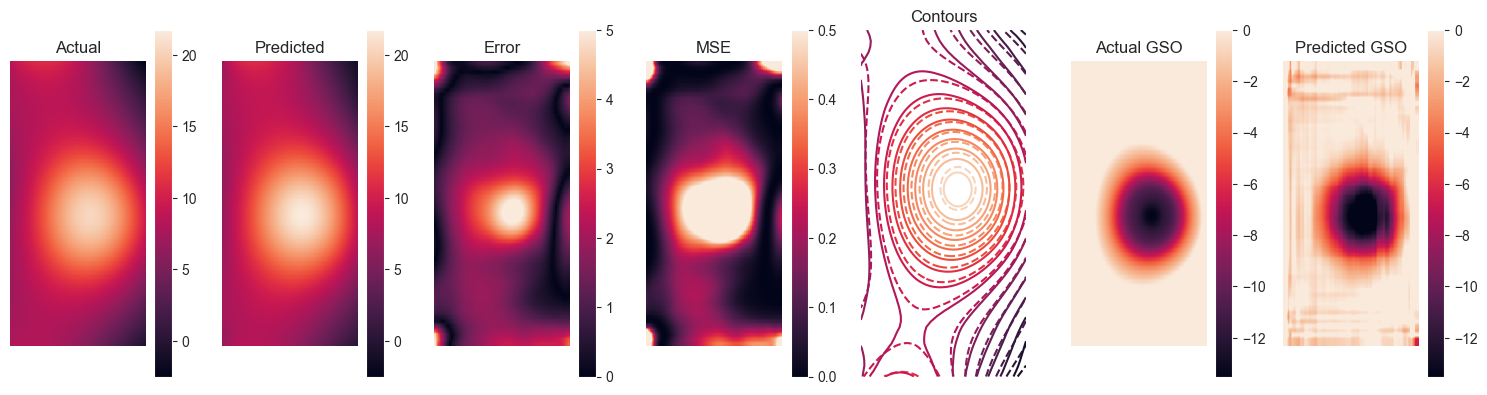

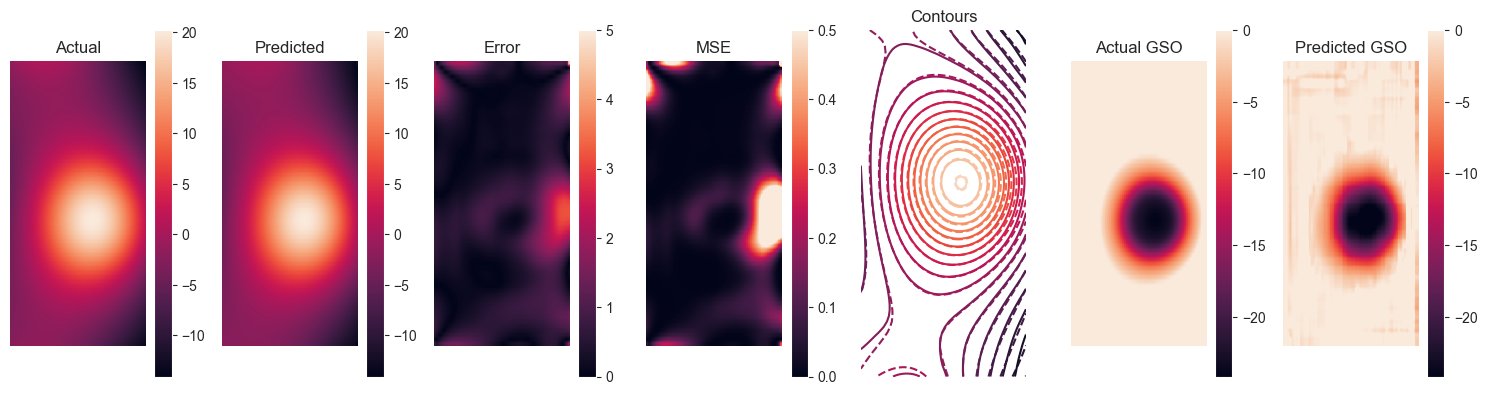

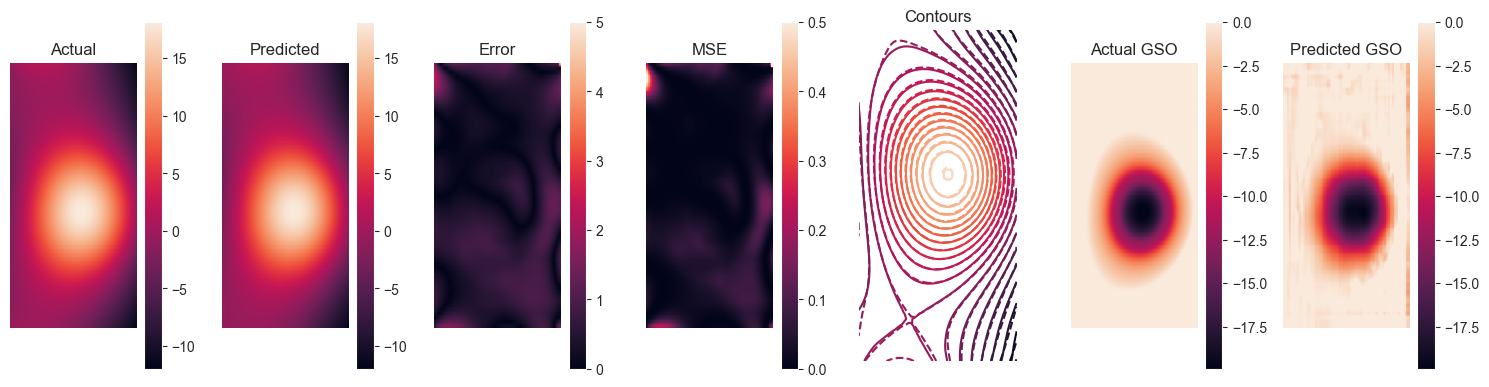

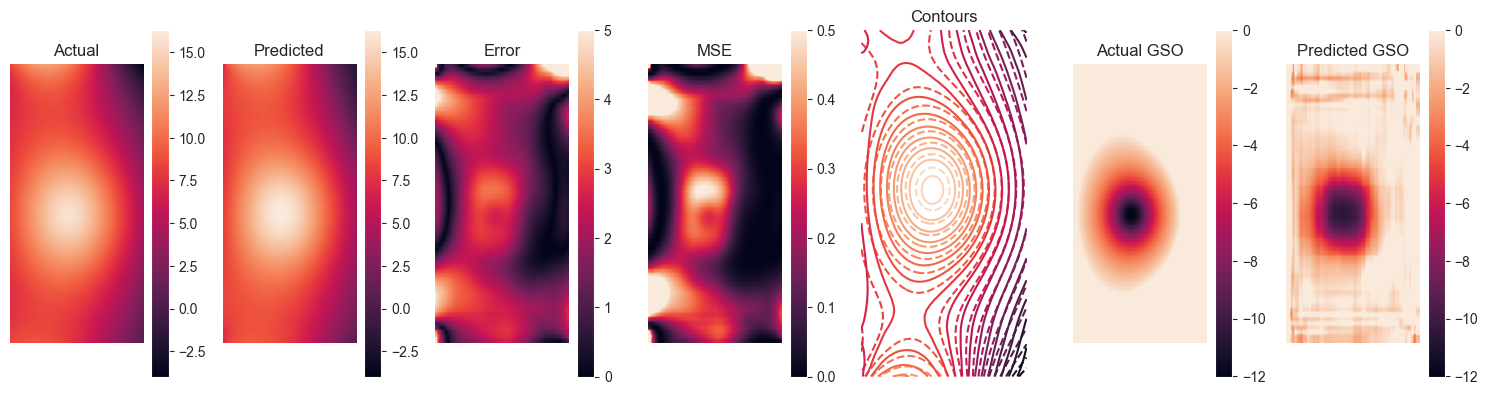

In [19]:
# testing network output
model = PlaNet()
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval()
ds = PlaNetDataset(EVAL_DS_PATH)
# ds = PlaNetDataset(TRAIN_DS_PATH)
for i in np.random.randint(0, len(ds), 10):  
    fig, axs = plt.subplots(1, 7, figsize=(15, 4))
    input_currs, psi_ds, rr, zz = ds[i]
    input_currs, psi_ds, rr, zz = input_currs.view(1,-1), psi_ds.view(1,1,64,64), rr.view(1,1,64,64), zz.view(1,1,64,64)
    psi_pred = model(input_currs)
    gso, gso_pred = calc_gso_batch(psi_ds, rr, zz), calc_gso_batch(psi_pred, rr, zz)
    gso, gso_pred = gso.detach().numpy().reshape(64, 64), gso_pred.detach().numpy().reshape(64, 64)
    gso_range = (gso.max(), gso.min())
    psi_pred = psi_pred.detach().numpy().reshape(64, 64)
    psi_ds = psi_ds.detach().numpy().reshape(64, 64)
    rr, zz = rr.view(64, 64).detach().numpy(), zz.view(64, 64).detach().numpy()
    ext = [ds.rr.min(), ds.rr.max(), ds.zz.min(), ds.zz.max()]
    bmin, bmax = np.min([psi_ds, psi_pred]), np.max([psi_ds, psi_pred])
    err = np.abs(psi_ds - psi_pred)*100/abs(bmax - bmin)
    # err = np.abs(psi_ds - psi_pred)*100/abs((psi_ds + psi_pred)/2)
    err_mse = (psi_ds - psi_pred)**2

    im0 = axs[0].imshow(psi_ds, extent=ext, vmin=bmin, vmax=bmax)
    axs[0].set_title("Actual")
    axs[0].set_aspect('equal')
    fig.colorbar(im0, ax=axs[0]) 

    im1 = axs[1].imshow(psi_pred, extent=ext, vmin=bmin, vmax=bmax)
    axs[1].set_title("Predicted")
    axs[1].set_aspect('equal')
    fig.colorbar(im1, ax=axs[1])

    im2 = axs[2].imshow(err, extent=ext, vmin=0, vmax=5)
    axs[2].set_title("Error")
    axs[2].set_aspect('equal')
    fig.colorbar(im2, ax=axs[2])

    im3 = axs[3].imshow(err_mse, extent=ext, vmin=0, vmax=0.5)
    axs[3].set_title("MSE")
    axs[3].set_aspect('equal')
    fig.colorbar(im3, ax=axs[3])

    c0 = axs[4].contour(rr, zz, psi_ds, levels=20, linestyles='dashed')
    c1 = axs[4].contour(rr, zz, psi_pred, levels=20)
    axs[4].set_title("Contours")
    axs[4].set_aspect('equal')

    im5 = axs[5].imshow(gso, extent=ext, vmin=gso_range[1], vmax=gso_range[0])
    axs[5].set_title("Actual GSO")
    axs[5].set_aspect('equal')
    fig.colorbar(im5, ax=axs[5])

    im6 = axs[6].imshow(gso_pred, extent=ext, vmin=gso_range[1], vmax=gso_range[0])
    axs[6].set_title("Predicted GSO")
    axs[6].set_aspect('equal')
    fig.colorbar(im6, ax=axs[6])

    for ax in axs: ax.axis('off')

    plt.tight_layout()
    plt.show()